<div style="font-size:450%;font-weight:600;text-align:center;color:#0277bd;height:40px;margin-top:20px;">
    2<span style="font-size:60%;color:red;">.</span> Features
</div>

# Libraries

In [2]:
# standard
from pathlib import Path

# data
import numpy as np
import pandas as pd

In [3]:
from sklearn.feature_selection import chi2, SelectKBest, f_classif, mutual_info_classif, VarianceThreshold

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sb

In [4]:
sb.set(style='whitegrid', context='talk')

# Config

In [5]:
exec(Path('scripts/loader.py').read_bytes())    # this will load the ScriptLoader class into global namespace
scripts = ScriptLoader(prefix='scripts')  # each script path, if not absolute, will be prefixed with `prefix` value

In [6]:
scripts.load('data')

script "data.py" read and loaded into namespace


In [7]:
scripts.load('features')

script "features.py" read and loaded into namespace


In [8]:
scripts.load('pd_tools')

script "pd_tools.py" read and loaded into namespace


In [9]:
scripts.load('plot')

script "plot.py" read and loaded into namespace


# Data

In [10]:
# `read_data` is in `data.py`
data = read_data(mmap=True)
m, n = data.shape

# New features (phase 1)

Have a look at the `new_features` dict to see which new feature will be added

In [11]:
list(new_features)

['Claim Flag']

In [12]:
# `make_new_features` is in `features.py`
make_new_features(data)  # this change the data inplace. Creates 'Claim Flag' feature

# Target selection

see the `Target` class for more information and its default instance `target`, in particular the `target.known` attribute which list all the known targets.

In [13]:
target.name  # this is the default target (original feature 'Claim Count')

'Claim Count'

In [14]:
target.known

['Claim Flag', 'Claim Count']

In [15]:
target.set('Claim Flag')  # set the new target

'Claim Flag'

# (original) Features selection

Have a look at the `features_exclusion` dict to see which feature I remove, and why ("why" is represented by the key of the dict)

In [16]:
features_exclusion

{'leaking': ['Claim Incurred',
  'Capped Incurred (£50k)',
  'Capped Incurred (£100k)'],
 'has_proxy': ['Trade 1', 'Trade 2']}

In [17]:
# `split_xyz` is in `features.py`
# split X and target, and remove leaking features + other targets (put in z)
x, y, z = split_xyz(data)

In [18]:
# `exclude_features` is in `features.py`
# put the additional removed features into z (with leaking features)
x, z = exclude_features(x, return_removed=z)

In [19]:
print('removed features:')
for _ in z:
    print(f'  - {_}')
print(f'and targets:\n  - {target.flatten_known()}')

removed features:
  - Claim Count
  - Claim Incurred
  - Capped Incurred (£50k)
  - Capped Incurred (£100k)
  - Trade 1
  - Trade 2
and targets:
  - ['Claim Flag', 'Claim Count']


# Cleaning

`tranforms` is an instance of `Transforms` (in `features.py` script), that keeps track of the transformations applied to the data, and will be able to re-apply the same logic to new data (with `transforms.apply(data)`).

In [20]:
# `clean_texts` is in `features.py`
clean_texts(x, replace_nan_with='')    # strip (remove leading/trailing spaces) and lower case text features

In [21]:
# `exclude_non_informative` is in `features.py`
exclude_non_informative(x)  # remove uninformative features (with NaN or just one value)

{'CancellationEffectiveDate': 'uninformative', 'Policy Count': 'unique value'}

In [22]:
# `replace_nan` is in `features.py`
# replace NaNs in float features (try to best choose a value, eg. min() - std()).
# If necessary, create a new feature to flag the NaN location
replace_float_nan(x) # return NaN replacement values dict, new flag. features, and NaN counts

({'Gross PI Premium': -613.5476250412831},
 {'Gross PI Premium_nan_flag': 'Gross PI Premium'},
 {'Gross PI Premium': 35138})

# Features: tests and decisions

In this part, we are looking at the features values (for each dtype), and decide what to do with them (keep, transform, drop, ...)

In [91]:
dtypes = get_dtypes(x)

there are 8 different types
   -  8 (13.3%) features of type "object"
   - 43 (71.7%) features of type "int64"
   -  3 ( 5.0%) features of type "datetime64[ns]"
   -  6 (10.0%) features of type "float64"


## Float features

In [71]:
dtypes['float64']

['Tools Sum Insured',
 'Total Gross Premium excl IPT',
 'Commission Amount',
 'Net Premium to UW',
 'Gross Premium Excl PI',
 'Gross PI Premium']

In [23]:
# `filter_by_dtype` is in `pd_tools.py`
xf = filter_by_dtype(x, float)

For the float features, we look at how they relate to the target value (ie. get a sense of their relative a-priori importance). To that purpose, we use the F-test and MI scores.

Also, we have a look at how the data is distributed and how the different target classes correlate to that distribution.

In [24]:
# `compute_corr_scores_classif` is in `plot.py`
# compute the F-test and Mutual information (for classification) on the whole data
scores_all = compute_corr_scores_classif(xf, y, 'f', 'mi', split=False, random_seed=43)

In [25]:
# same as above, but split the data into K sets (to balance classes), and average the scores on 3 runs
# (each run has its own random shuffling)
scores = compute_corr_scores_classif(xf, y, 'f', 'mi', split=True, ratio=1., random_seed=43, runs=3)

splitting has been required. There are 2 classes, and we will balance them according to the majority and minority classes,"1" (1.40%) and "0" (98.60%) resp.
splitting into 71 sets
>> starting run #1...
  doing set 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, last set (71).
>> starting run #2...
  doing set 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, last set (71).
>> starting run #3...
  doing set 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,

In [26]:
pal = sb.cubehelix_palette(xf.shape[1], rot=-.5, dark=.3)

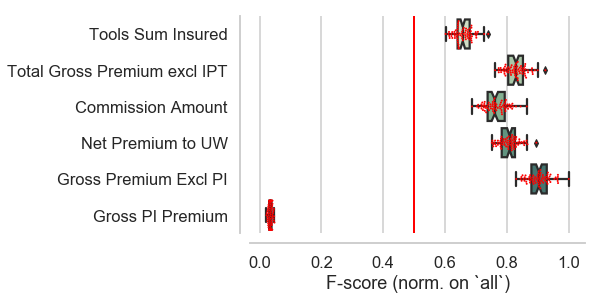

In [27]:
# `plot_split_scores` is in `plot.py`
plot_split_scores(scores['f_test'], list(xf), 'F-score', norm='all', palette=pal)

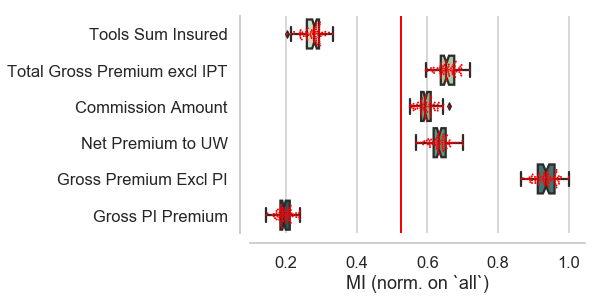

In [28]:
plot_split_scores(scores['mi'], list(xf), 'MI', norm='all', palette=pal)

In [29]:
# for comparison, the scores obtained when calculated on the whole dataset
sa = pd.DataFrame({_: s[0] / s[0].max() for _, s in scores_all.items()}, copy=True)
sa.loc[:, 'features'] = list(xf)
sa

f_test        mi                      features
0  0.441357  0.400892             Tools Sum Insured
1  0.905397  0.707287  Total Gross Premium excl IPT
2  0.791563  0.635086             Commission Amount
3  0.913366  0.698106             Net Premium to UW
4  1.000000  1.000000         Gross Premium Excl PI
5  0.015739  0.935396              Gross PI Premium

See how the target classes are fractioned alon the each features distribution

In [ ]:
# `fractions_per_target_classes` is in `pd_tools.py`
classes, fracs, bin_edges = fractions_per_target_classes(xf, y, bins=20)

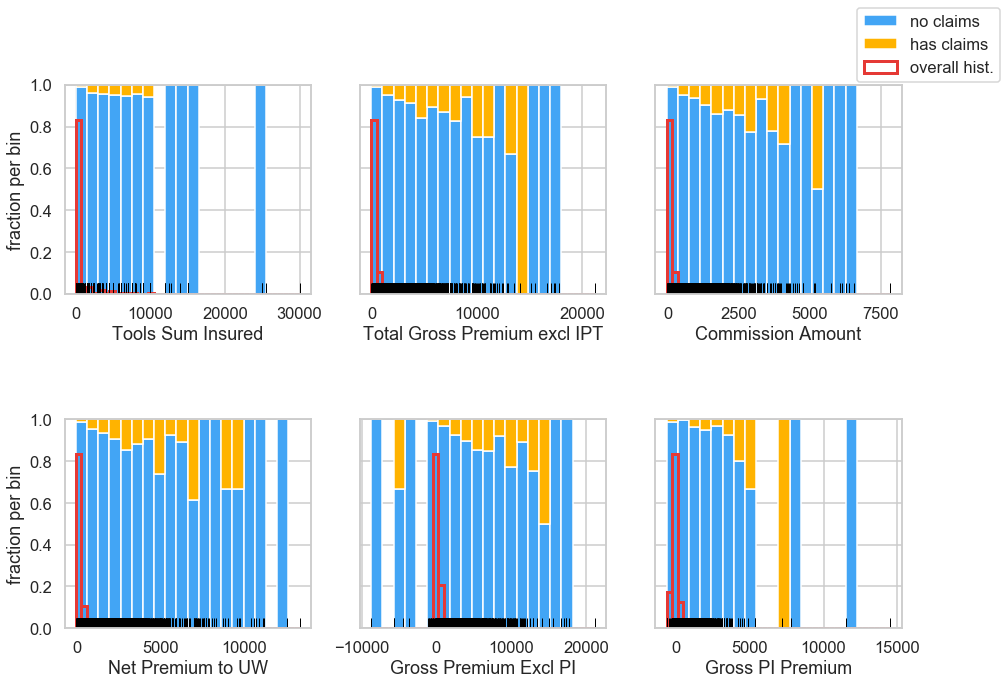

In [31]:
# `plot_fractions_per_classes` is in `plot.py`
fig = plot_fractions_per_classes(
    xf,
    classes=classes, fracs=fracs, bin_edges=bin_edges,                       
    parts='hist, rug',
    class_legend={0: 'no claims', 1: 'has claims'},
    class_colors=('#42a5f5', '#ffb300')
)

In [286]:
# unique values in each float feature
for c in xf:
    print(c, xf[c].unique().size)

Tools Sum Insured 60
Total Gross Premium excl IPT 53423
Commission Amount 34306
Net Premium to UW 44698
Gross Premium Excl PI 49398
Gross PI Premium 10652


<span style="color: red;font-weight: 600;font-size: 150%;">==> Thus:</span>

From this incomplete exploration, we can see that out of the 6 float features, 4 will matter more.

## Text features

In [72]:
dtypes['object']

['Source System',
 'Product',
 'Transaction Type',
 'Match Type',
 'Trade 1 Category',
 'Trade 2 Category',
 'Location',
 'Risk_Postcode2']

In [33]:
xt = filter_by_dtype(x, object)

In [35]:
print_counts(xt)

Source System................. has     2 unique and     0 NaNs/null values .................Source System
Product....................... has     6 unique and     0 NaNs/null values .......................Product
Transaction Type.............. has     2 unique and     0 NaNs/null values ..............Transaction Type
Match Type.................... has     8 unique and     0 NaNs/null values ....................Match Type
Trade 1 Category.............. has    16 unique and     0 NaNs/null values ..............Trade 1 Category
Trade 2 Category.............. has    17 unique and     0 NaNs/null values ..............Trade 2 Category
Location...................... has   122 unique and     0 NaNs/null values ......................Location
Risk_Postcode2................ has  9769 unique and     0 NaNs/null values ................Risk_Postcode2


In [36]:
xt.head(15)

Source System             Product Transaction Type   Match Type  \
0   simply business  maltings tradesman     new business  min premium   
1   simply business  maltings tradesman     new business          0.1   
2   simply business  maltings tradesman     new business            5   
3   simply business  maltings tradesman     new business            1   
4   simply business  maltings tradesman     new business  min premium   
5   simply business  maltings tradesman     new business            1   
6   simply business  maltings tradesman     new business          0.1   
7   simply business  maltings tradesman     new business          0.1   
8   simply business  maltings tradesman     new business          0.1   
9   simply business  maltings tradesman     new business          0.1   
10  simply business  maltings tradesman     new business          0.1   
11  simply business  maltings tradesman     new business            5   
12  simply business  maltings tradesman     new business  min premium   
13  simply business  maltings tradesman     new business          0.1   
14  simply business  maltings tradesman     new business          0.1   

       Trade 1 Category Trade 2 Category             Location Risk_Postcode2  
0       building/allied                              brighton         bn21 3  
1       building/allied                               bristol         bs15 4  
2      hvac/mech/allied                           northampton         nn10 8  
3          professional                             cambridge          cb8 7  
4          professional                   newcastle upon tyne          ne5 1  
5       building/allied     professional    south east london         se14 5  
6       building/allied                               romford          rm1 4  
7      hvac/mech/allied                                bolton          bl7 9  
8       building/allied                                               tm34 2  
9      hvac/mech/allied  building/allied             southall          ub7 7  
10  decorators/flooring                             llandudno         ll55 4  
11         professional                             salisbury          sp8 4  
12         professional                        stoke-on-trent         st19 9  
13      building/allied                           east london          e17 7  
14              decline                              bradford         bd18 1

What to do with `Location` and `Risk_Postcode2`? They have a large number of values, so **one-hot-encoding** them would take lot of memory and/or processing time. A possible way to deal with them is a **Leave-One-Out encoding**, which would create just one new feature for each, but would use the target information to do so (careful  about leaking and therefore overfitting). This Leave-One-Out would be best used in a cross-validation scheme in which one fold of the data would serve to encode these 2 features, do regular cross-validation on the n-2 next folds, and test on the last fold. For simplicity and rapidity here, we might omit (drop) these 2 features altogether.

For the others, **One-Hot-Encode** the features seem reasonable.

## Integer features

In [95]:
dtypes['int64']

['Underwriting Year',
 'Public Liability Limit',
 'Employers Liability Limit',
 'Professional Indemnity Limit',
 'Contract Works Sum Insured',
 'Hired in Plan Sum Insured',
 'Own Plant Sum Insured',
 'Manual EE',
 'Clerical EE',
 'Subcontractor EE',
 'Trade 1 Risk Level',
 'Trade 2 Risk Level',
 'DurationofPolicy',
 'CombinedTradeRiskLevel',
 'Public_Liability_Limit_1000000',
 'Public_Liability_Limit_1000000.1',
 'Public_Liability_Limit_2000000',
 'Public_Liability_Limit_5000000',
 'Public_Liability_Limit_5000000.1',
 'Public_Liability_Limit_1000000.2',
 'Public_Liability_Limit_1000000.3',
 'Employers_Liability_Limit_1000',
 'Professional_Indemnity_Limit_5',
 'Professional_Indemnity_Limit_5.1',
 'Professional_Indemnity_Limit_1',
 'Professional_Indemnity_Limit_1.1',
 'Professional_Indemnity_Limit_2',
 'Professional_Indemnity_Limit_2.1',
 'Professional_Indemnity_Limit_5.2',
 'Professional_Indemnity_Limit_5.3',
 'Professional_Indemnity_Limit_1.2',
 'Professional_Indemnity_Limit_1.3',
 'Pr

In [96]:
xi = filter_by_dtype(x, int)

In [98]:
print_counts(xi)

Underwriting Year.................. has     5 unique values
Public Liability Limit............. has     4 unique values
Employers Liability Limit.......... has     2 unique values
Professional Indemnity Limit....... has     7 unique values
Contract Works Sum Insured......... has    28 unique values
Hired in Plan Sum Insured.......... has    67 unique values
Own Plant Sum Insured.............. has   120 unique values
Manual EE.......................... has    23 unique values
Clerical EE........................ has    22 unique values
Subcontractor EE................... has    18 unique values
Trade 1 Risk Level................. has    12 unique values
Trade 2 Risk Level................. has    14 unique values
DurationofPolicy................... has   128 unique values
CombinedTradeRiskLevel............. has    13 unique values
Public_Liability_Limit_1000000..... has     2 unique values
Public_Liability_Limit_1000000.1... has     2 unique values
Public_Liability_Limit_2000000..... has 

`Underwriting Year` is a categorical: **One-Hot-Encode** it. (the natural order of years would need to be treated carefully if used, with proper time-series technique and knowledge ; here we just assume that what happened in a given year has no natural consequence on other years - in a time-series sense)

`Gross PI Premium_nan_flag` is a categorical too, but can be left as it is, since 1="with value", and 0="no value" (hence numerical values have a natural order, ie. penalize samples with no information on that feature).

All other features can be used without further treatment, as they represent numerical quantities.

In [110]:
fi_not_cat = [_ for _ in xi if _ not in ('Gross PI Premium_nan_flag', 'Underwriting Year')]

In [111]:
scores_all_int = compute_corr_scores_classif(xi.loc[:, fi_not_cat], y, 'f', 'mi', split=False, random_seed=43)

In [112]:
# the scores obtained when calculated on the whole dataset
sai = pd.DataFrame({_: s[0] / s[0].max() for _, s in scores_all_int.items()}, copy=True)
sai.loc[:, 'features'] = fi_not_cat
sai

f_test        mi                          features
0   0.078455  0.355536            Public Liability Limit
1   0.641181  0.520406         Employers Liability Limit
2   0.160187  0.094292      Professional Indemnity Limit
3   0.391164  0.020653        Contract Works Sum Insured
4   0.651549  0.040746         Hired in Plan Sum Insured
5   0.259010  0.034967             Own Plant Sum Insured
6   0.468341  0.544150                         Manual EE
7   0.014148  0.047673                       Clerical EE
8   0.060458  0.010546                  Subcontractor EE
9   0.573869  0.281164                Trade 1 Risk Level
10  0.197461  0.062667                Trade 2 Risk Level
11  0.000151  1.000000                  DurationofPolicy
12  0.594912  0.273704            CombinedTradeRiskLevel
13  0.103894  0.279347    Public_Liability_Limit_1000000
14  0.005291  0.000000  Public_Liability_Limit_1000000.1
15  0.008575  0.160630    Public_Liability_Limit_2000000
16  0.061777  0.081986    Public_Liability_Limit_5000000
17  0.005291  0.006064  Public_Liability_Limit_5000000.1
18  0.103894  0.271625  Public_Liability_Limit_1000000.2
19  0.005291  0.013194  Public_Liability_Limit_1000000.3
20  0.641181  0.169627    Employers_Liability_Limit_1000
21  0.004817  0.004379    Professional_Indemnity_Limit_5
22  0.022846  0.004339  Professional_Indemnity_Limit_5.1
23  0.015210  0.000000    Professional_Indemnity_Limit_1
24  0.133669  0.030156  Professional_Indemnity_Limit_1.1
25  0.020569  0.006158    Professional_Indemnity_Limit_2
26  0.016813  0.006855  Professional_Indemnity_Limit_2.1
27  0.004817  0.001431  Professional_Indemnity_Limit_5.2
28  0.022846  0.017265  Professional_Indemnity_Limit_5.3
29  0.015210  0.005587  Professional_Indemnity_Limit_1.2
30  0.133669  0.029420  Professional_Indemnity_Limit_1.3
31  0.020569  0.003647  Professional_Indemnity_Limit_2.2
32  0.016813  0.004236  Professional_Indemnity_Limit_2.3
33  1.000000  0.082763             Tools_Sum_Insured_Ind
34  0.355351  0.011242    Contract_Works_Sum_Insured_Ind
35  0.756889  0.042022     Hired_in_Plan_Sum_Insured_Ind
36  0.463094  0.026703         Own_Plant_Sum_Insured_Ind
37  0.061777  0.073053  Public_Liability_Limit_5000000.2
38  0.005291  0.000000  Public_Liability_Limit_5000000.3
39  0.237737  0.126323    Professional_Indemnity_Limit_g
40  0.247048  0.224651                    TotalEmployees

## Date features

In [133]:
dtypes['datetime64[ns]']

['Effective Date', 'Expiry Date', 'Effective_Date2']

In [263]:
xd = filter_by_dtype(x, 'M')

In [264]:
xd.head()

Effective Date         Expiry Date Effective_Date2
0 2014-09-19 01:00:00 2015-09-18 01:00:00      2014-09-19
1 2014-10-08 01:00:00 2015-10-07 01:00:00      2014-10-08
2 2014-09-18 01:00:00 2015-09-17 01:00:00      2014-09-18
3 2014-10-03 01:00:00 2015-10-02 01:00:00      2014-10-03
4 2014-09-20 01:00:00 2015-09-19 01:00:00      2014-09-20

Most likely don't need `Effective Date2` as `Effective Date` contains all information.

Our approach with dates here is to treat their parts (year, month, day) as categoricals, and compute the length (duration) of the policy as a new numerical feature (`Expiry Date - Effective Date`), in days.

In [282]:
scripts.load('features')

script "features.py" read and loaded into namespace


In [283]:
# `split_date_periods` is in `features.py`
xds = split_date_periods(xd, ('Effective Date', 'Expiry Date'), inplace=False, drop_originals=True)

In [284]:
xds.head()

Effective_Date2  Effective Date [year]  Effective Date [month]  \
0      2014-09-19                   2014                       9   
1      2014-10-08                   2014                      10   
2      2014-09-18                   2014                       9   
3      2014-10-03                   2014                      10   
4      2014-09-20                   2014                       9   

   Effective Date [day]  Expiry Date - Effective Date [days]  
0                    19                                  364  
1                     8                                  364  
2                    18                                  364  
3                     3                                  364  
4                    20                                  364

In [287]:
# apply to the final X
split_date_periods(x, ('Effective Date', 'Expiry Date'), inplace=True, drop_originals=True)

In [ ]:
# drop the remaining `Effective_Date2` feature, not needed anymore
x.drop(['Effective_Date2'], axis=1, inplace=True)

# Export

We do not finalize data here (eg. one-hot-encode, scaling), because first it'd take much more space to save on disk (and would take more time to write/read), and because this leaves further liberty to test strategies while trying different modeling approaches.

In [409]:
# `export` is in `data.py`
export(x, basename='X', fmt='hdf5',
       finalization=dict(categoricals=['Underwriting Year'], drop=['Effective_Date2']))

PosixPath('/Users/mhavel/Documents/working/jupyter/Entretiens_Jobs_tests/QBE/outputs/X.h5')

In [410]:
# `export` is in `data.py`
export(x, basename='X', fmt='csv',
       finalization=dict(categoricals=['Underwriting Year'], drop=['Effective_Date2']))

PosixPath('/Users/mhavel/Documents/working/jupyter/Entretiens_Jobs_tests/QBE/outputs/X.csv.bz2')

In [425]:
export(y, basename='Y', fmt='hdf5')
export(y, basename='Y', fmt='csv')

PosixPath('/Users/mhavel/Documents/working/jupyter/Entretiens_Jobs_tests/QBE/outputs/Y.csv.bz2')